In [1]:
import cv2
import numpy as np

import torch as th
import torch.nn.functional as F

# video rendering deps
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import imageio
from IPython.display import Video

import gym
import gym_minigrid
import hwm.gym_minigrid_2.fourroom_cstm # custom FourRoom envs
from gym_minigrid.wrappers import ReseedWrapper
from hwm.gym_minigrid_2.wrappers import RGBImgFullGridWrapper, ChannelFirstImgWrapper, \
    RGBImgResizeWrapper, ActionMaskingWrapper, FactoredStateRepWrapper, RenderWithoutHighlightWrapper

from stable_baselines3 import PPO
# from stable_baselines3.common.env_util import make_vec_env

import os
from typing import Any, Callable, Dict, Optional, Type, Union
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecEnv

def make_vec_env(
    env_id: Union[str, Type[gym.Env]],
    n_envs: int = 1,
    seed: Optional[int] = None,
    start_index: int = 0,
    monitor_dir: Optional[str] = None,
    wrapper_class: Optional[Callable[[gym.Env], gym.Env]] = None,
    env_kwargs: Optional[Dict[str, Any]] = None,
    vec_env_cls: Optional[Type[Union[DummyVecEnv, SubprocVecEnv]]] = None,
    vec_env_kwargs: Optional[Dict[str, Any]] = None,
    monitor_kwargs: Optional[Dict[str, Any]] = None,
    wrapper_kwargs: Optional[Dict[str, Any]] = None,
    ) -> VecEnv:
    """
    Create a wrapped, monitored ``VecEnv``.
    By default it uses a ``DummyVecEnv`` which is usually faster
    than a ``SubprocVecEnv``.

    :param env_id: the environment ID or the environment class
    :param n_envs: the number of environments you wish to have in parallel
    :param seed: the initial seed for the random number generator
    :param start_index: start rank index
    :param monitor_dir: Path to a folder where the monitor files will be saved.
        If None, no file will be written, however, the env will still be wrapped
        in a Monitor wrapper to provide additional information about training.
    :param wrapper_class: Additional wrapper to use on the environment.
        This can also be a function with single argument that wraps the environment in many things.
    :param env_kwargs: Optional keyword argument to pass to the env constructor
    :param vec_env_cls: A custom ``VecEnv`` class constructor. Default: None.
    :param vec_env_kwargs: Keyword arguments to pass to the ``VecEnv`` class constructor.
    :param monitor_kwargs: Keyword arguments to pass to the ``Monitor`` class constructor.
    :param wrapper_kwargs: Keyword arguments to pass to the ``Wrapper`` class constructor.
    :return: The wrapped environment
    """
    env_kwargs = {} if env_kwargs is None else env_kwargs
    vec_env_kwargs = {} if vec_env_kwargs is None else vec_env_kwargs
    monitor_kwargs = {} if monitor_kwargs is None else monitor_kwargs
    wrapper_kwargs = {} if wrapper_kwargs is None else wrapper_kwargs

    def make_env(rank):
        def _init():
            env = gym.make(env_id, **env_kwargs)
            
            if not wrapper_kwargs["no_reseed"]:
                env = ReseedWrapper(env, seeds=wrapper_kwargs["env_seeds"])
            else:
                env.seed(seed + rank)
                env.action_space.seed(seed + rank)
            
            if len(wrapper_kwargs["env_masked_actions"]):
                env = ActionMaskingWrapper(env, invalid_actions_list=wrapper_kwargs["env_masked_actions"])
            
            env = FactoredStateRepWrapper(env)
            env = RenderWithoutHighlightWrapper(env)

            # Wrap the env in a Monitor wrapper
            # to have additional training information
            monitor_path = os.path.join(monitor_dir, str(rank)) if monitor_dir is not None else None
            # Create the monitor folder if needed
            if monitor_path is not None:
                os.makedirs(monitor_dir, exist_ok=True)
            env = Monitor(env, filename=monitor_path, **monitor_kwargs)
            # Optionally, wrap the environment with the provided wrapper
            if wrapper_class is not None:
                env = wrapper_class(env, **wrapper_kwargs)
            return env

        return _init

    # No custom VecEnv is passed
    if vec_env_cls is None:
        # Default: use a DummyVecEnv
        vec_env_cls = DummyVecEnv

    return vec_env_cls([make_env(i + start_index) for i in range(n_envs)], **vec_env_kwargs)


In [2]:
# Dataset parameterization
# Parallel environments
ENV_NAME = "MiniGrid-FourRooms-Size11-v0"

wrapper_kwargs = {
    "no_reseed": False,
    "env_seeds": [222],
    "env_masked_actions": ["pickup", "drop", "toggle", "done"]
}
env = make_vec_env(ENV_NAME, n_envs=1, wrapper_kwargs=wrapper_kwargs)

# Set dataset filename
dataset_filename = f"datasets/{ENV_NAME}_SB3_PPOAgent_WithFactStates"

# Agent SB3 model loading
model = PPO.load("models/PPO_MiniGrid-FourRooms-Size11-v0_Agent")

In [3]:
obs = env.reset()
dones = np.zeros(1)
video_data = [env.render(mode="rgb_array")]
while dones.sum() < 1:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    video_data.append(env.render(mode="rgb_array"))

video_data = np.array(video_data, dtype=np.uint8)
imageio.mimwrite('/tmp/observer_video.mp4', video_data, fps=4)
IPython.display.display(Video("/tmp/observer_video.mp4", html_attributes="controls autoplay loop"))
# video_data.shape

## Generating dataset

In [4]:
TRAIN_DATASET_SIZE = int(1e3)

# agent_pov_obs_shape = agent_obs_data.shape[1:]
observer_obs_shape = video_data.shape[1:]
agent_pov_obs_shape = (64,64,3) # Note: PPO uses 84x84x3 though
act_shape = env.action_space.n

observer_obs_shape, agent_pov_obs_shape, act_shape

def generate_dataset(dataset_filename, max_steps, mode="Train"):
    dataset = {
        "observations": [],
        "actions": [], # alreayd one hot
        # "next_observations": np.zeros([DATASET_SIZE, *obs_shape]),
        "rewards": [],
        "terminals": [],
        "rendered_observations": [], # Human observer observations, usually higher dimension
        "factored_states": []
    }

    total_steps = 0

    while total_steps < max_steps:
        ep_obs, ep_rendered_obs, ep_actions, \
            ep_rewards, ep_terminals, ep_factored_states = \
            [], [], [], [], [], []
        
        obs = env.reset()
        dones = np.zeros(1)
        

        while dones.sum() < 1:
            rendered_obs = env.render(mode="rgb_array")

            with th.no_grad():
                action, _states = model.predict(obs)
            # Do one environment step
            next_obs, rewards, dones, info = env.step(action)
            # Save the data of the current time step
            onehot_action = np.eye(act_shape)[action[0]]

            ep_factored_states.append(obs[0])
            ep_actions.append(onehot_action)
            ep_rewards.append(rewards)
            ep_terminals.append(dones)
            # TODO: add permute to C,H,W directy here. Reduce computation during the training.
            ep_obs.append(
                cv2.resize(rendered_obs, agent_pov_obs_shape[:2],
                interpolation=cv2.INTER_AREA))
            ep_rendered_obs.append(rendered_obs)

            obs = next_obs

            total_steps += 1

            if total_steps % 5000 == 0 or total_steps == max_steps:
                print(f"Sampled {total_steps} / {max_steps}")
        
        # Episode done, append trajectory to the dataset
        # NOTE: using np.uint8 when possible decreased the required storage space
        # at least in system memory
        # Tranpose the observations from [T,H,W,C] to [T,C,H,W] to match Pytorchs requirement
        # and save computation time during training.
        dataset["observations"].append(np.array(ep_obs, dtype=np.uint8).transpose(0,3,1,2))
        dataset["actions"].append(np.array(ep_actions, dtype=np.uint8))
        dataset["rewards"].append(np.array(ep_rewards, dtype=np.float32))
        dataset["terminals"].append(np.array(ep_terminals, dtype=np.float32))
        dataset["rendered_observations"].append(np.array(ep_rendered_obs, dtype=np.uint8))
        dataset["factored_states"].append(np.array(ep_factored_states, dtype=np.uint8))

    # TODO: maybe add a metadata field into the dataset to stor ethe min and max lengths of trajectories
    # in the dataset, and so on.

    ep_lengths = [len(ep_terminal_list) for ep_terminal_list in dataset["terminals"]]
    dataset["max_length"] = int(np.max(ep_lengths))
    dataset["min_length"] = int(np.min(ep_lengths))
    dataset["act_shape"] = act_shape
    dataset["factored_state_shape"] = obs.shape[-1]
    dataset["observation_shape"] = ep_obs[-1].shape[::-1] # Breaks if the Height and width are different.
    dataset["rendered_observation_shape"] = ep_rendered_obs[-1].shape
    dataset["n_episodes"] = len(ep_lengths)

    # Save the collected data dict
    np.savez_compressed(f"{dataset_filename}_{mode}.npz", **dataset)

    return dataset

In [5]:
# Complete dset for HWM
train_dset = generate_dataset(dataset_filename, TRAIN_DATASET_SIZE)

Sampled 1000 / 1000


/home/d055/anaconda3/envs/hwm/lib/python3.8/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [7]:
# checking the dataset, namely the consistency of the various fields saved
print("obs. shape: ", train_dset["observations"][0].shape)
print("rendered obs. shape: ", train_dset["rendered_observations"][0].shape)
print("actions shape: ", train_dset["actions"][0].shape)
print("rewards shape: ", train_dset["rewards"][0].shape)
print("terminals shape: ", train_dset["terminals"][0].shape)
print("factored_states shape: ", train_dset["factored_states"][0].shape)
print("")
# Getting some stats from the dataset
ep_lengths = [len(ep_terminal_list) for ep_terminal_list in train_dset["terminals"]]
print(f"Mean ep. length: {np.mean(ep_lengths)}")
print(f"Median ep. length: {np.median(ep_lengths)}")
print(f"Min. ep. length: {np.min(ep_lengths)}")
print(f"Max. ep. length: {np.max(ep_lengths)}")
print(f"Std. Dev. ep. length: {np.std(ep_lengths)}")

# print(train_dset["metadata"])

obs. shape:  (7, 3, 64, 64)
rendered obs. shape:  (7, 352, 352, 3)
actions shape:  (7, 3)
rewards shape:  (7, 1)
terminals shape:  (7, 1)
factored_states shape:  (7, 36)

Mean ep. length: 11.420454545454545
Median ep. length: 11.0
Min. ep. length: 3
Max. ep. length: 22
Std. Dev. ep. length: 3.406950085383923


<ipython-input-8-f9ec992d7377>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, ep_length,


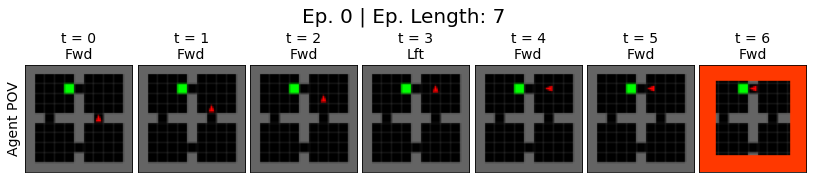

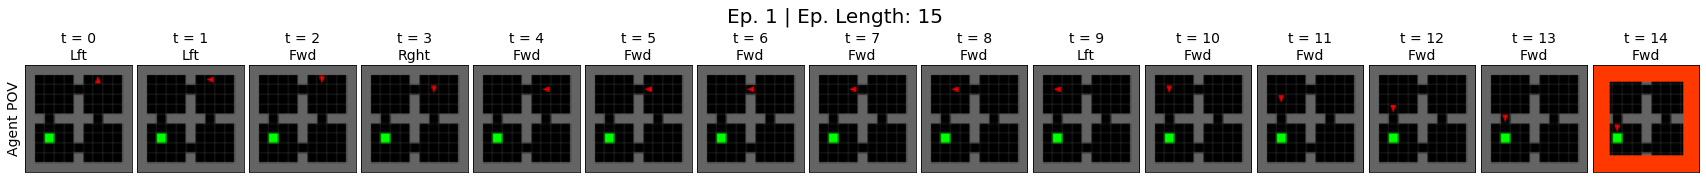

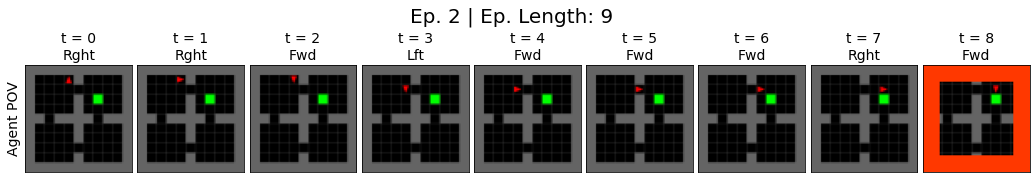

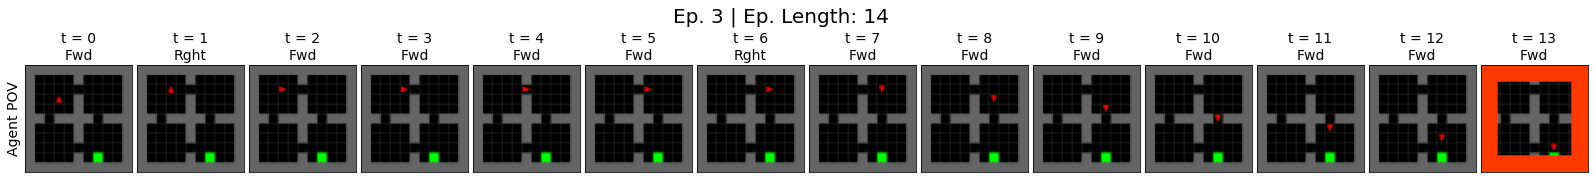

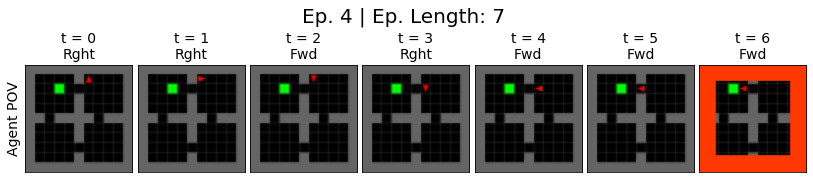

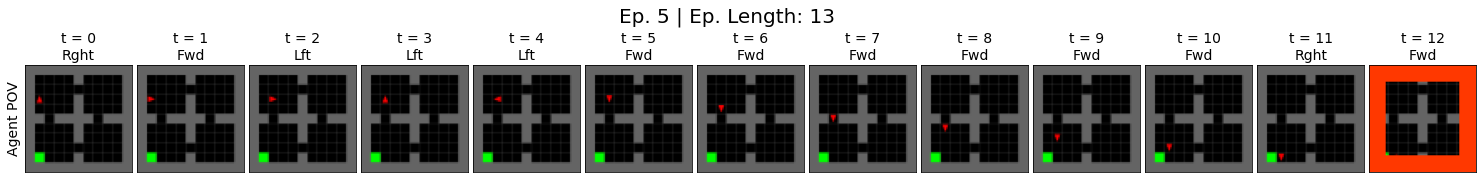

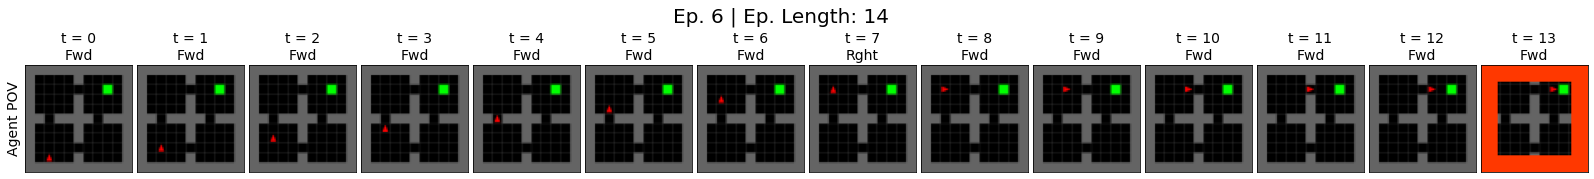

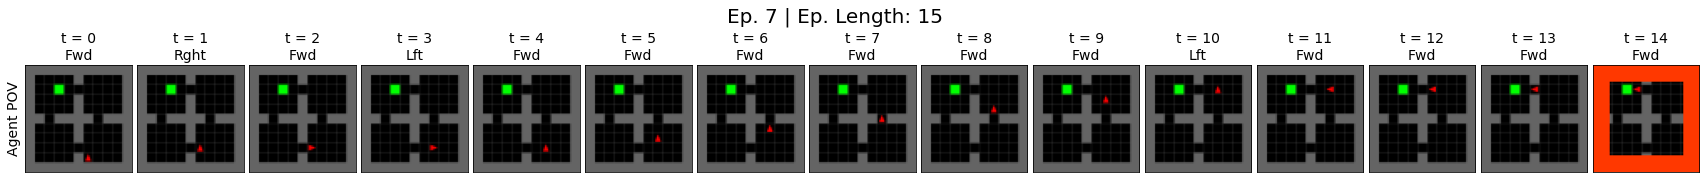

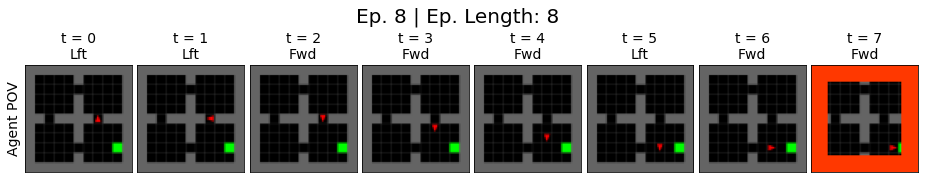

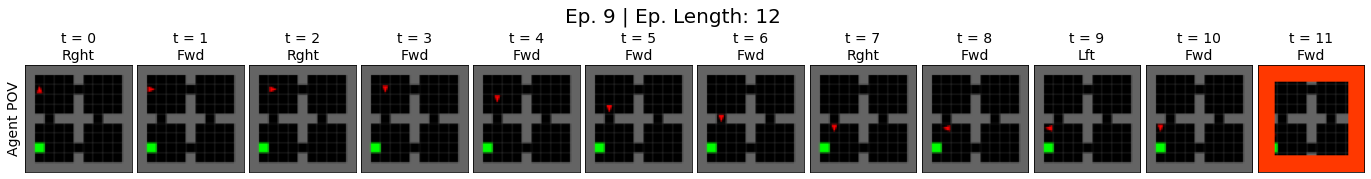

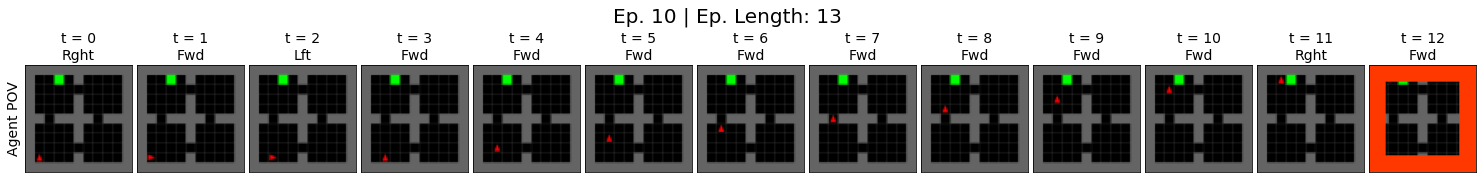

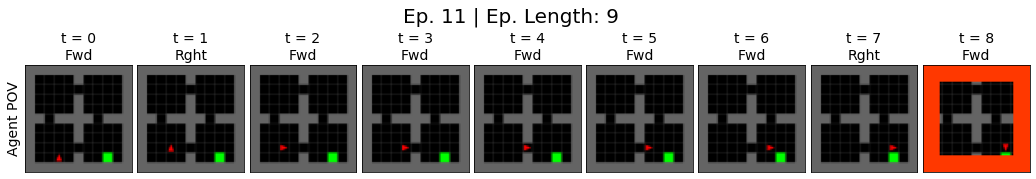

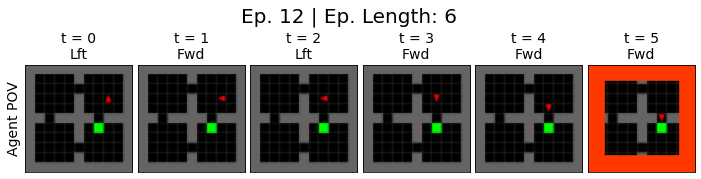

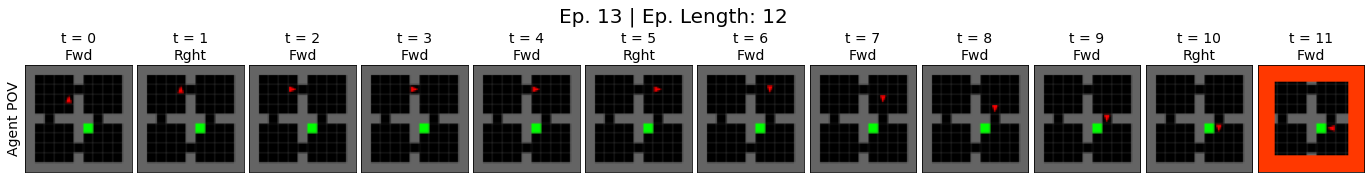

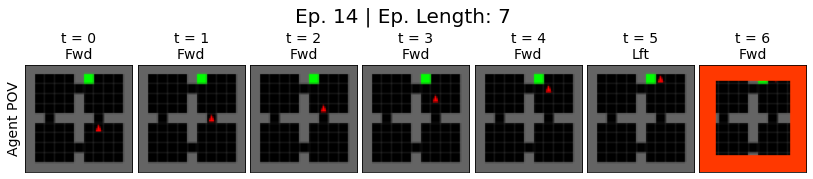

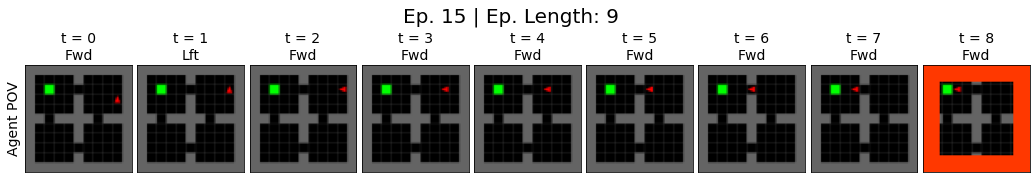

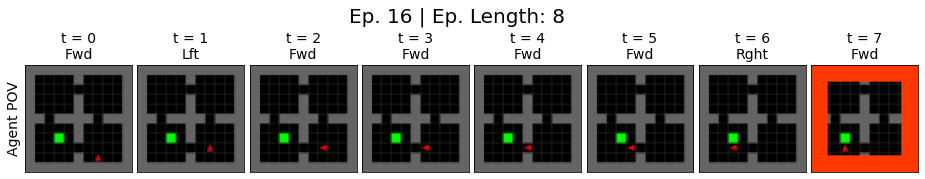

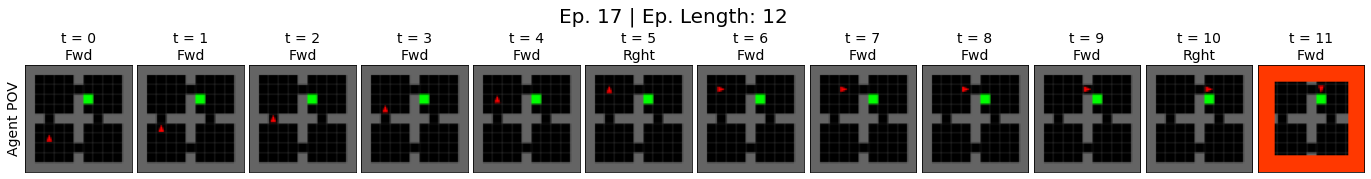

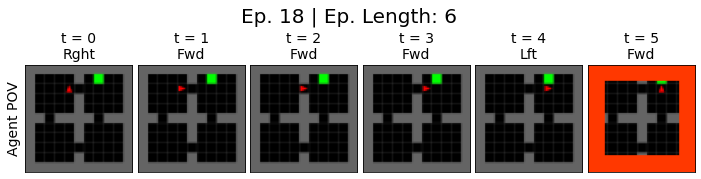

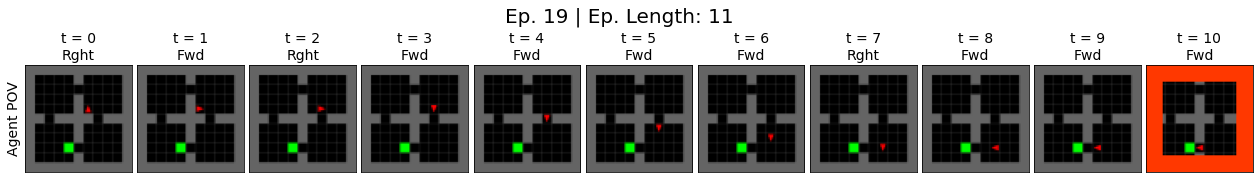

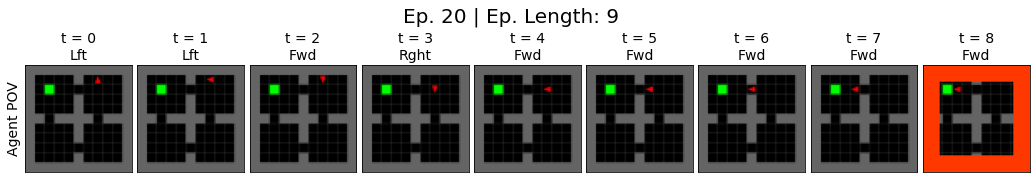

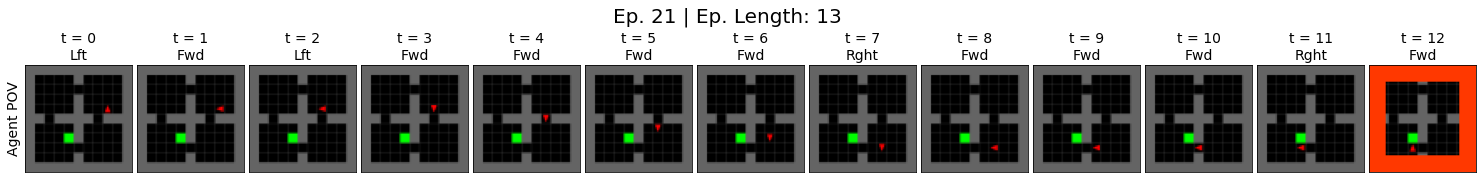

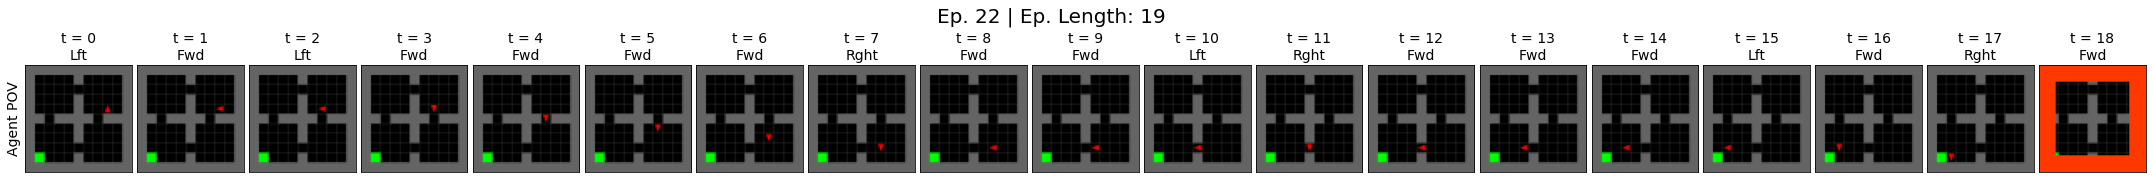

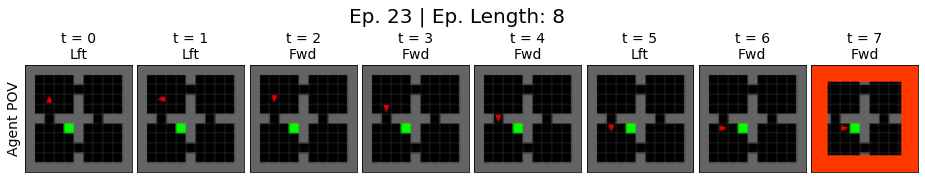

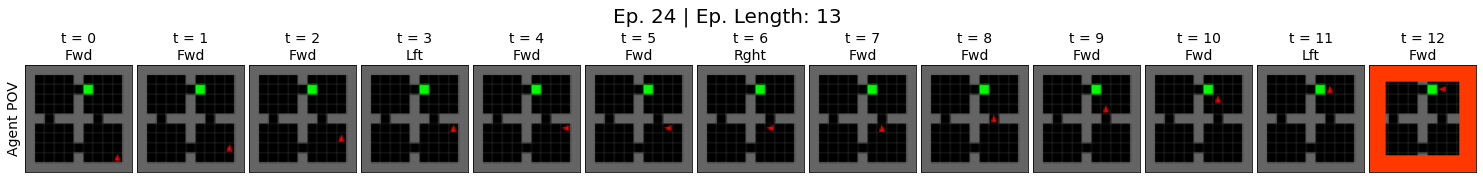

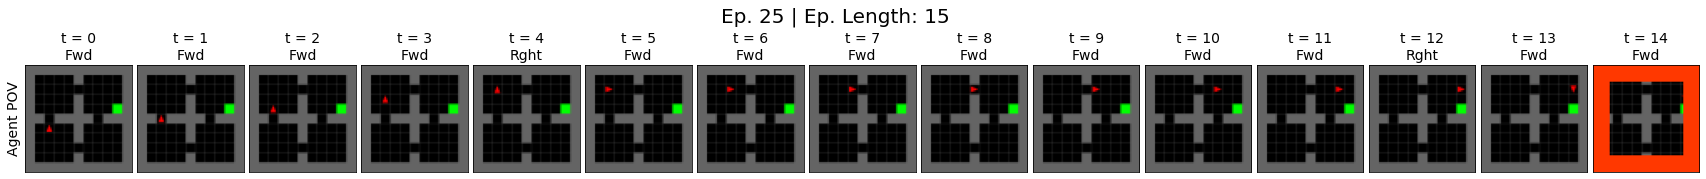

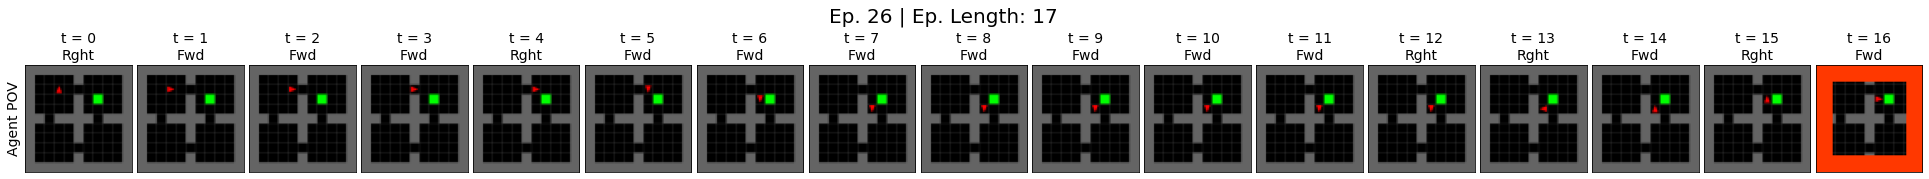

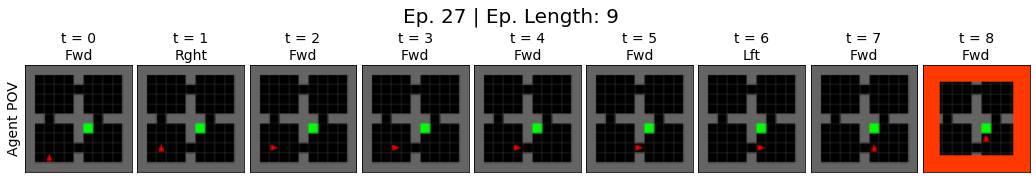

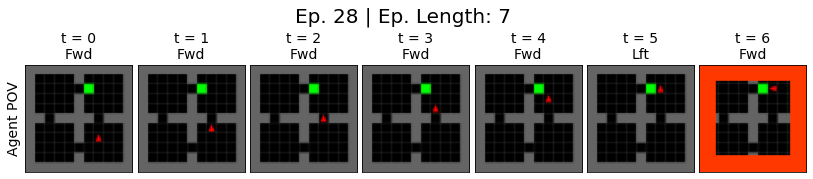

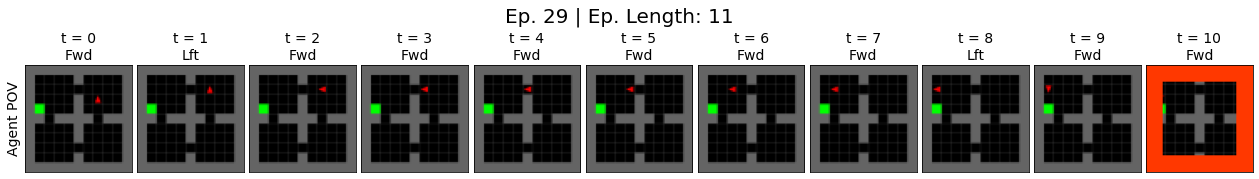

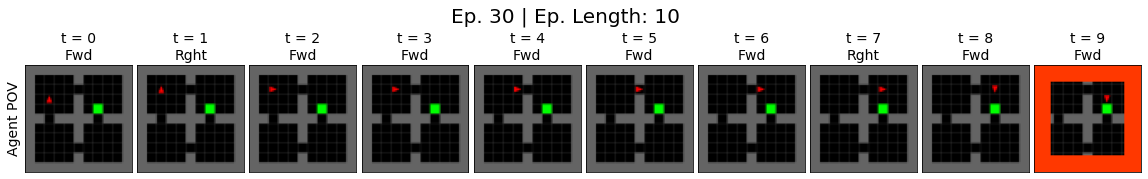

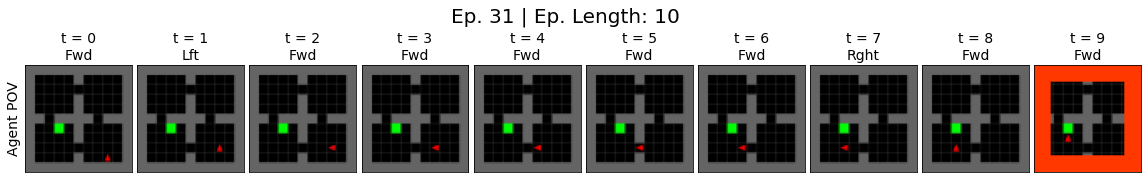

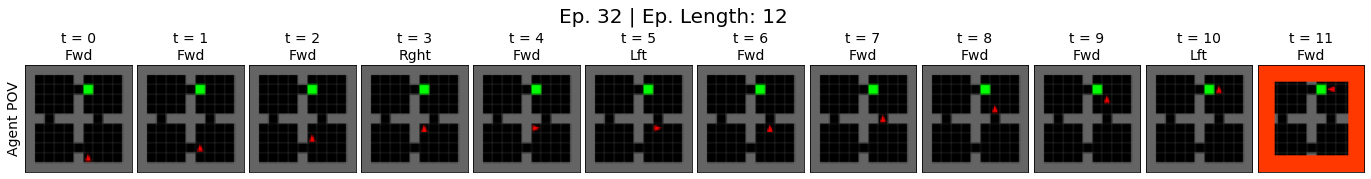

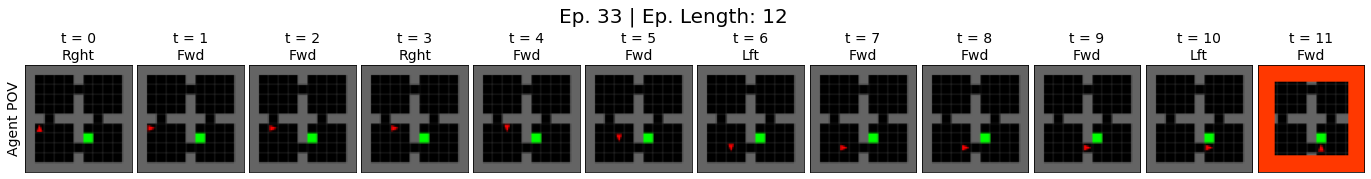

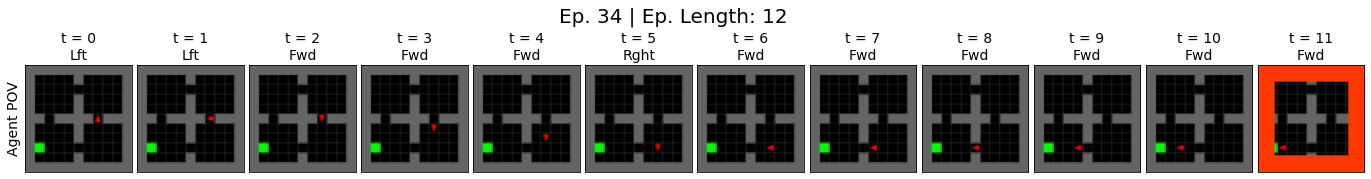

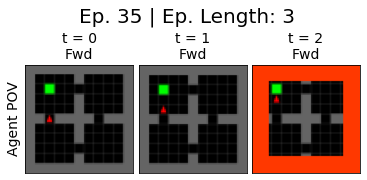

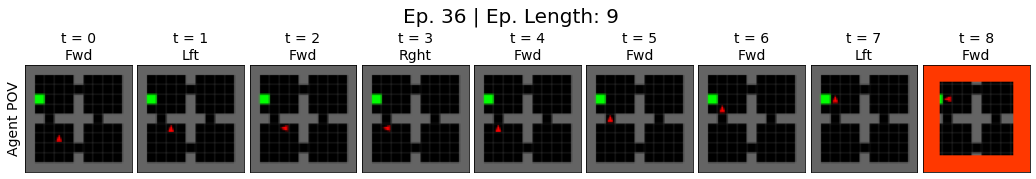

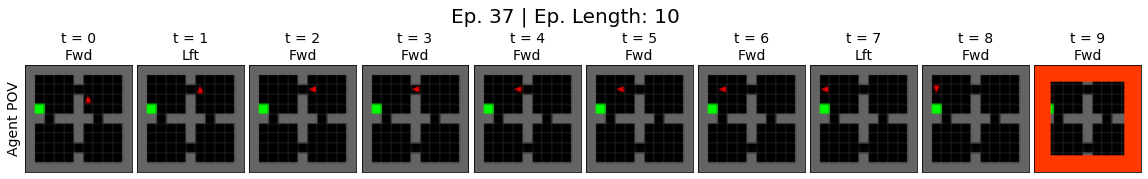

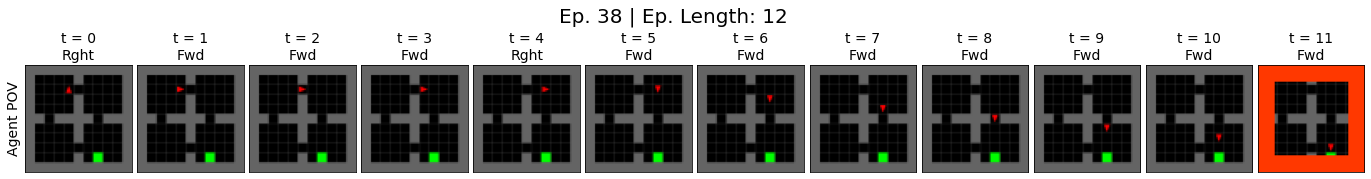

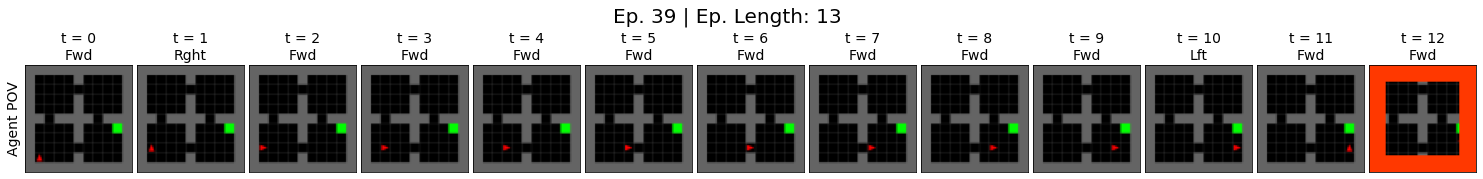

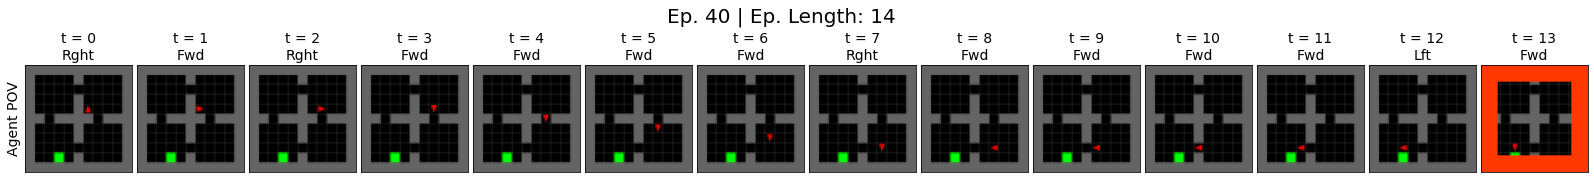

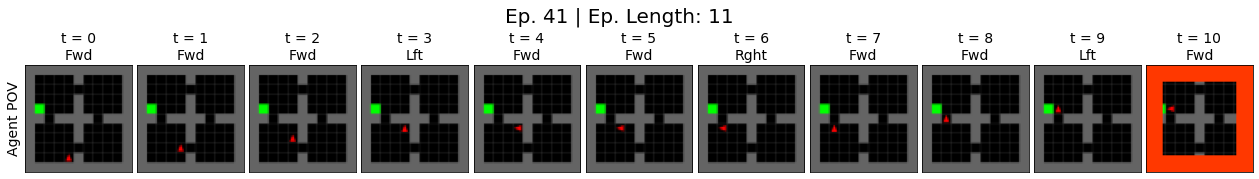

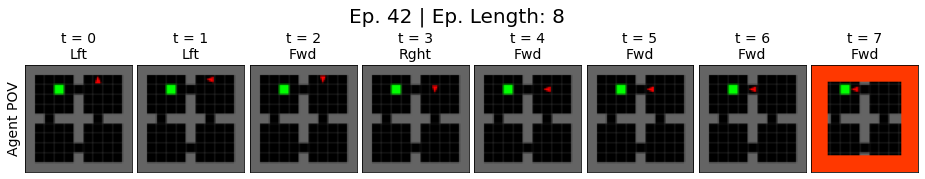

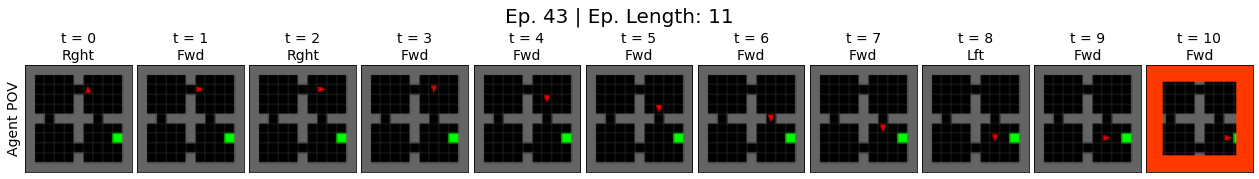

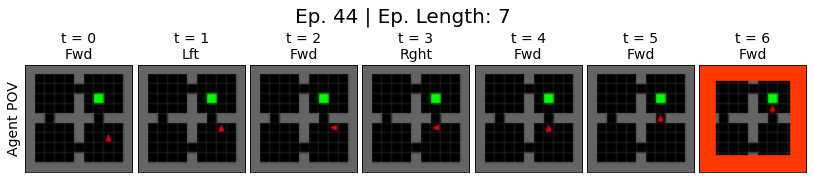

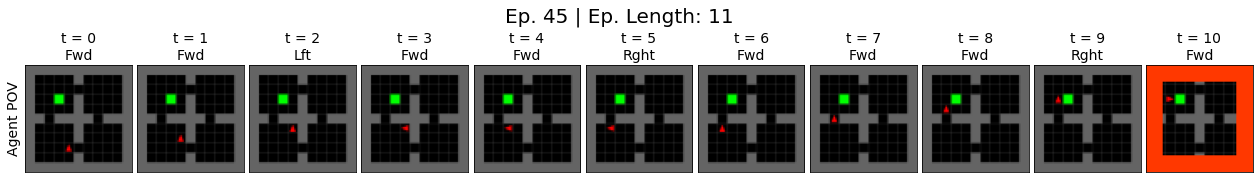

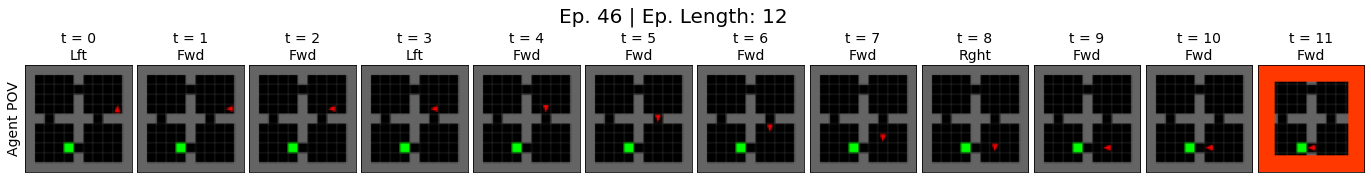

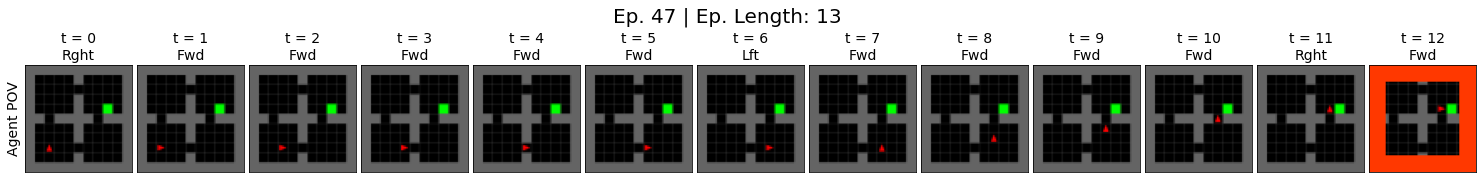

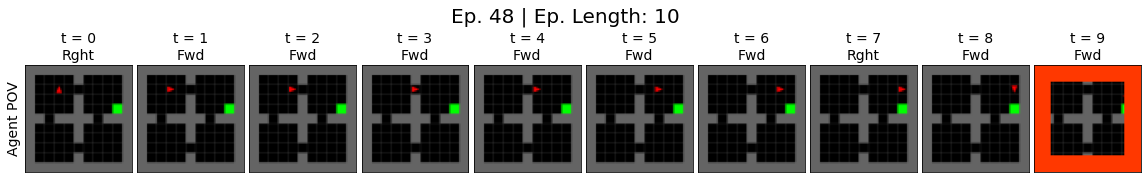

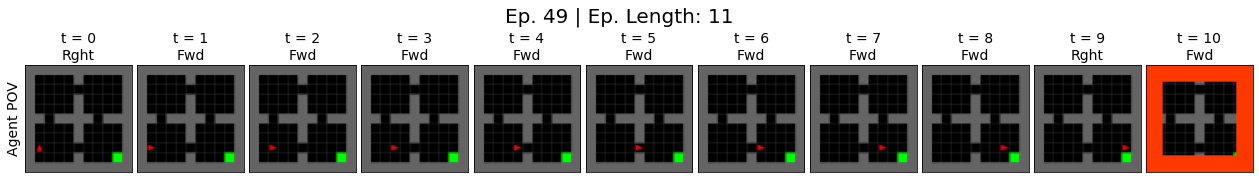

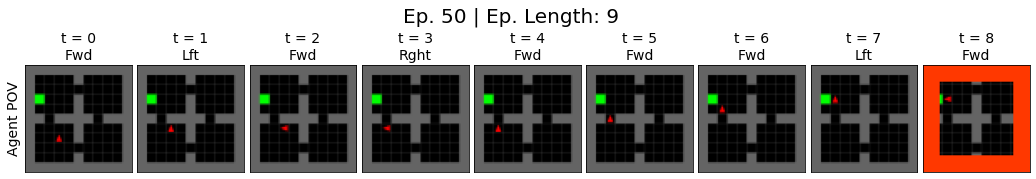

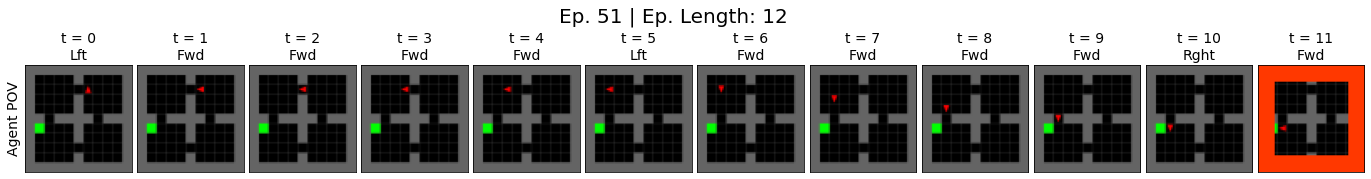

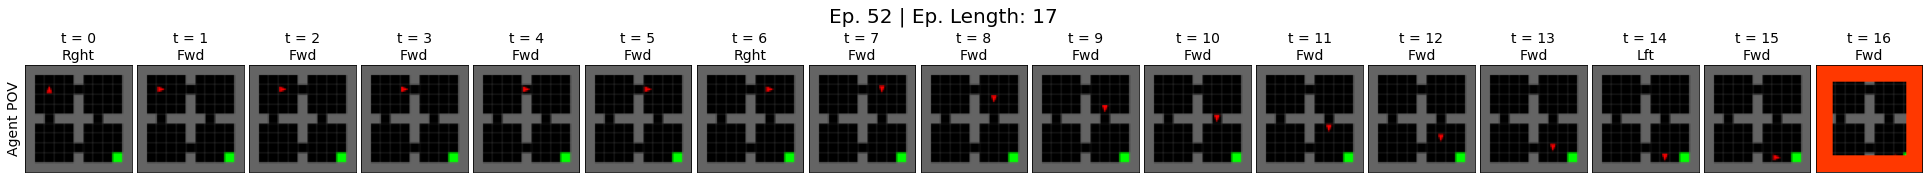

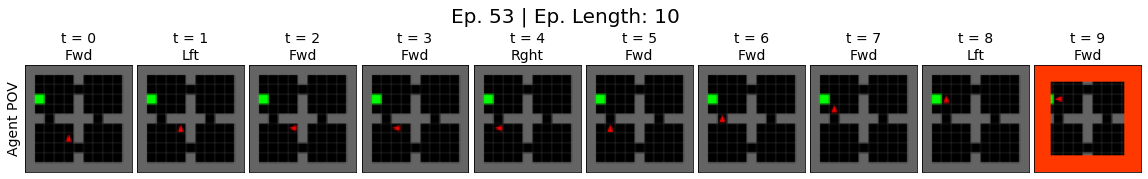

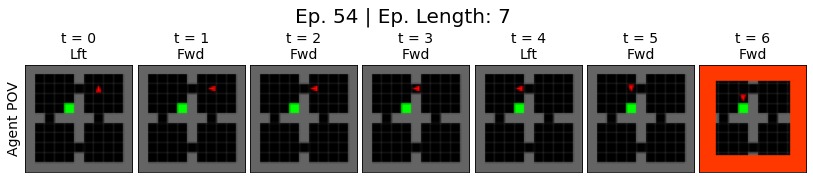

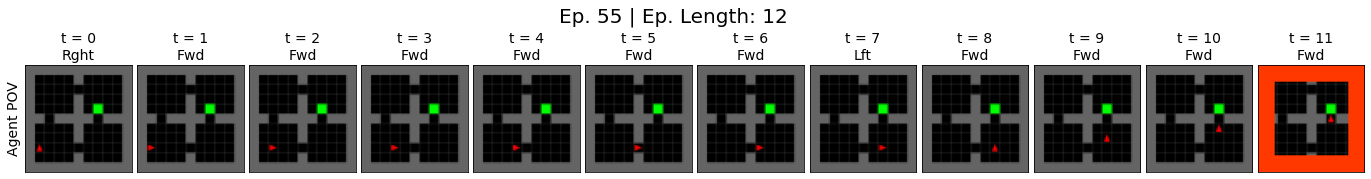

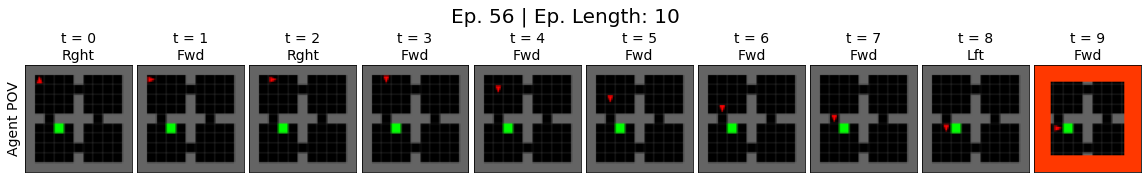

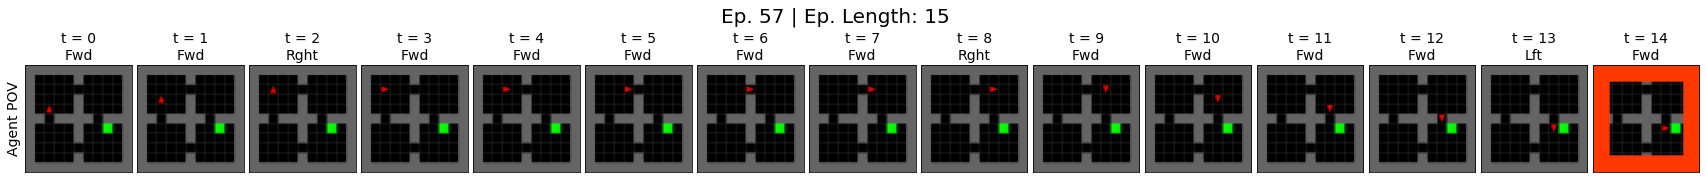

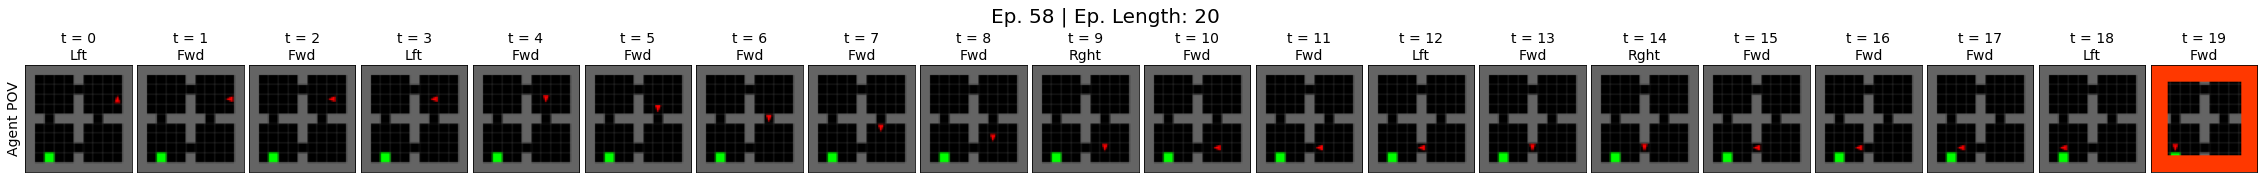

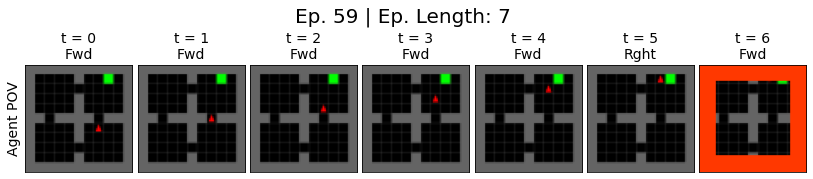

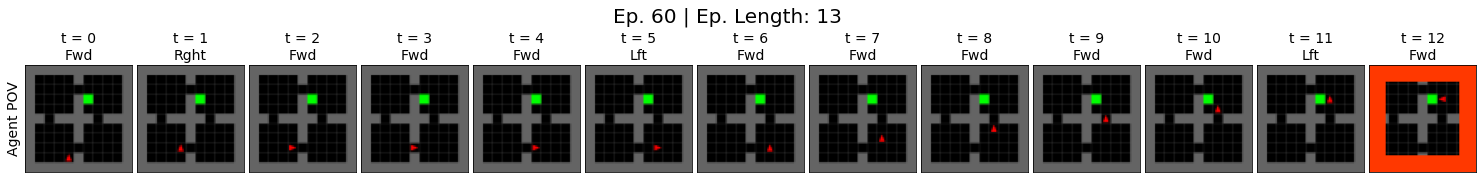

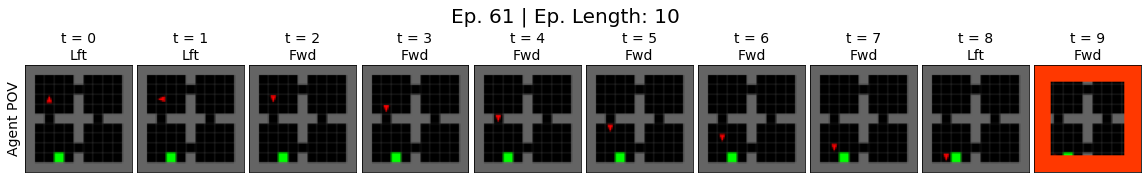

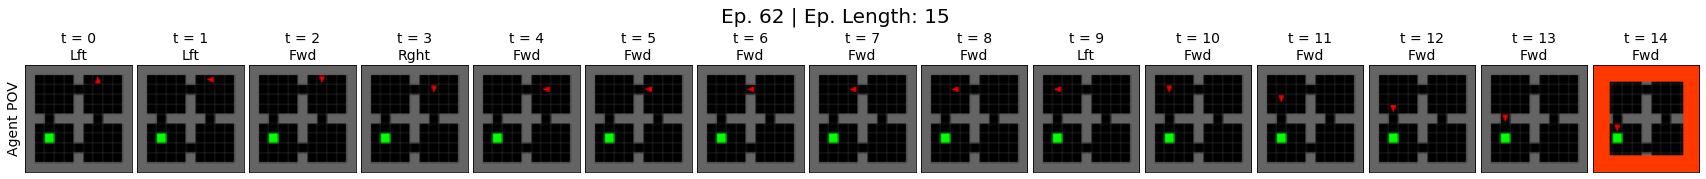

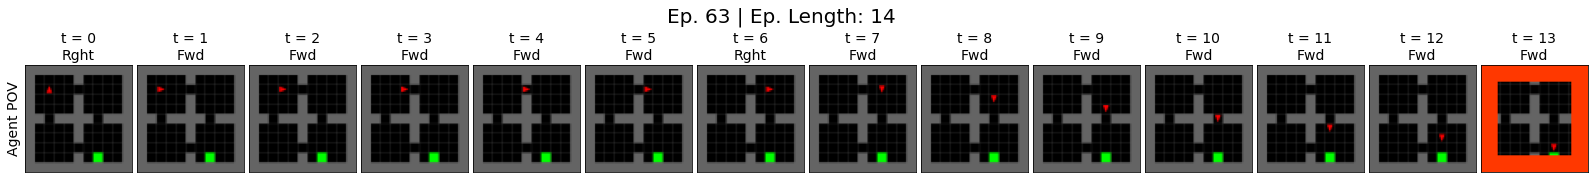

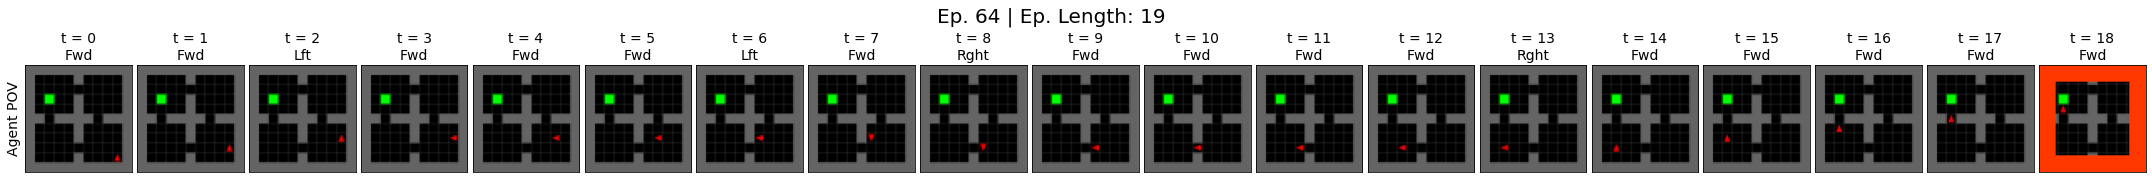

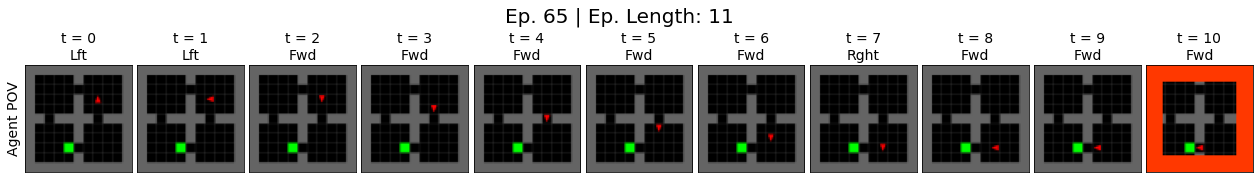

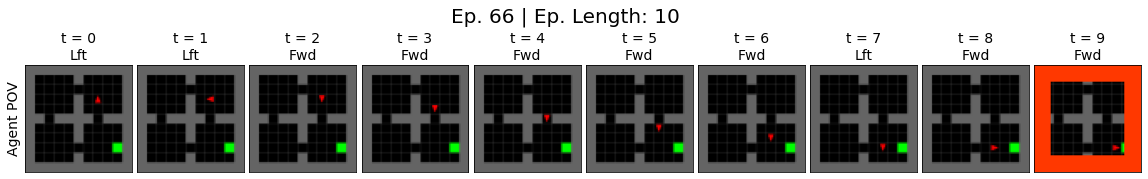

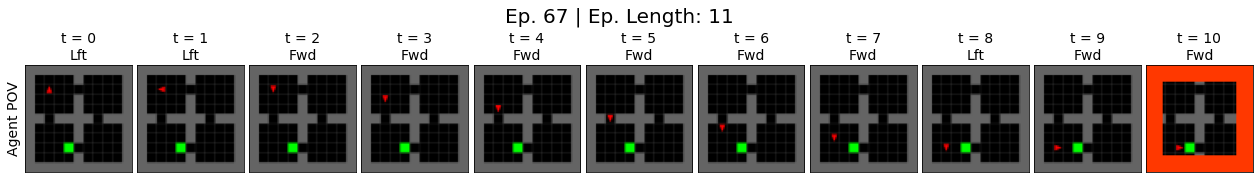

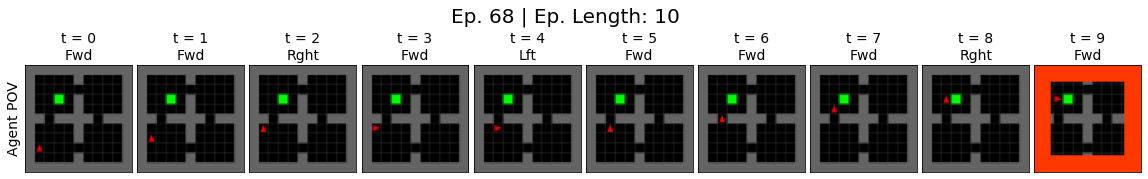

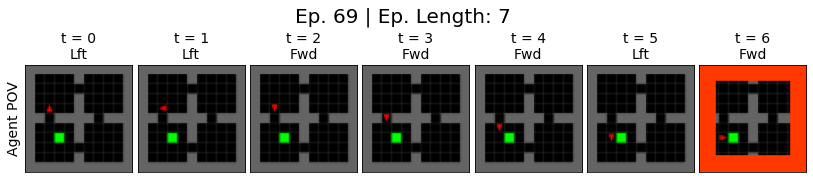

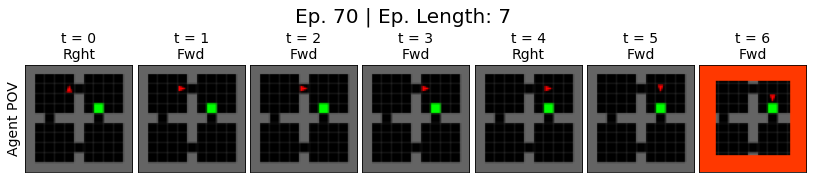

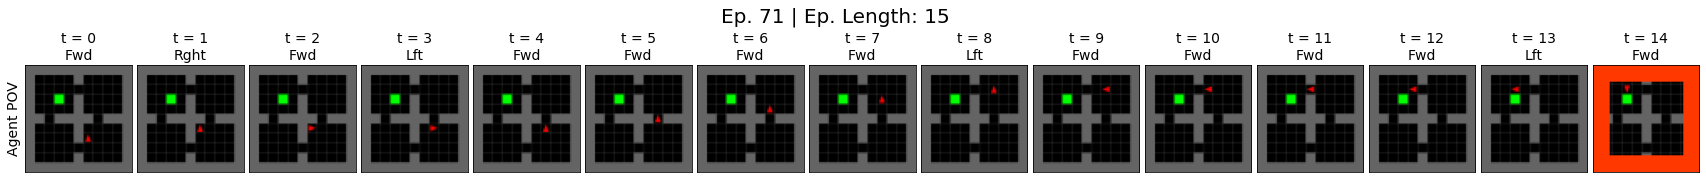

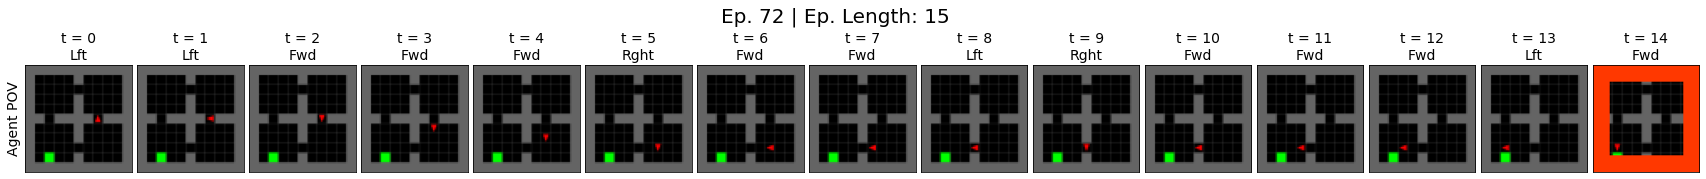

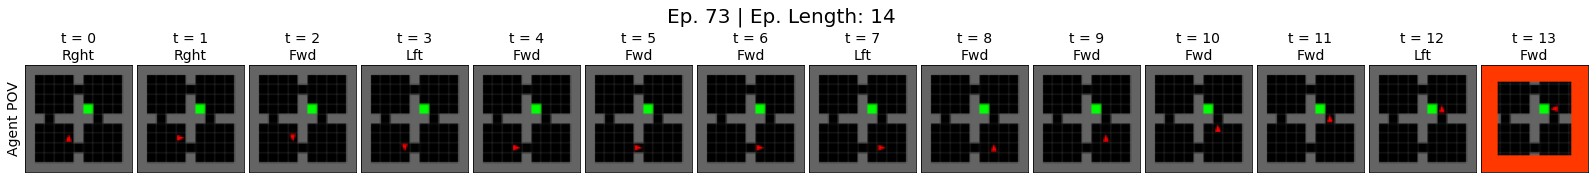

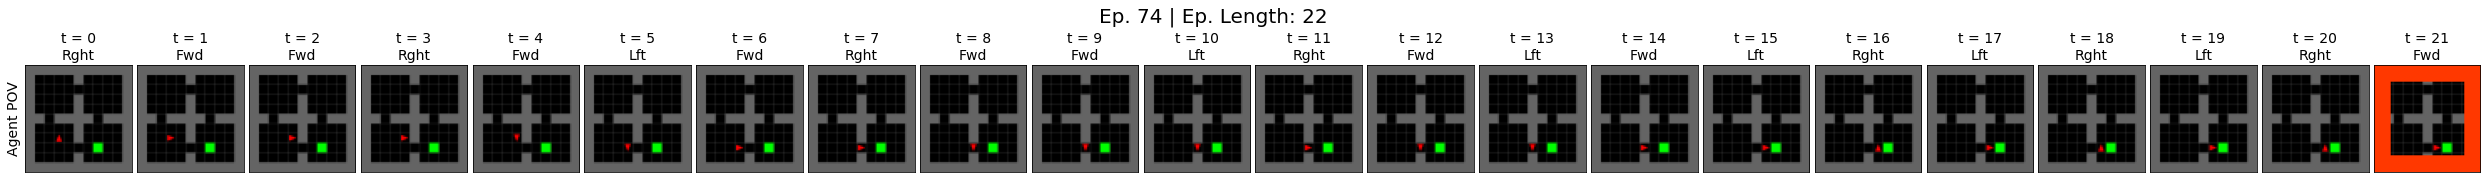

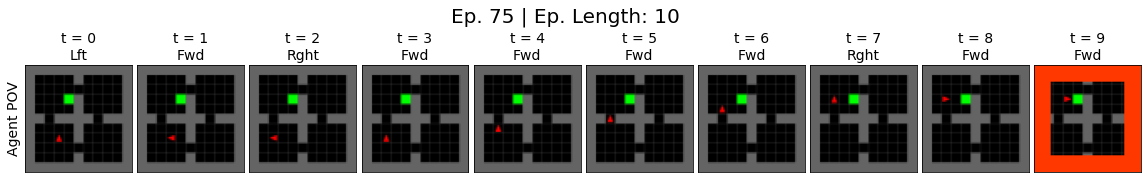

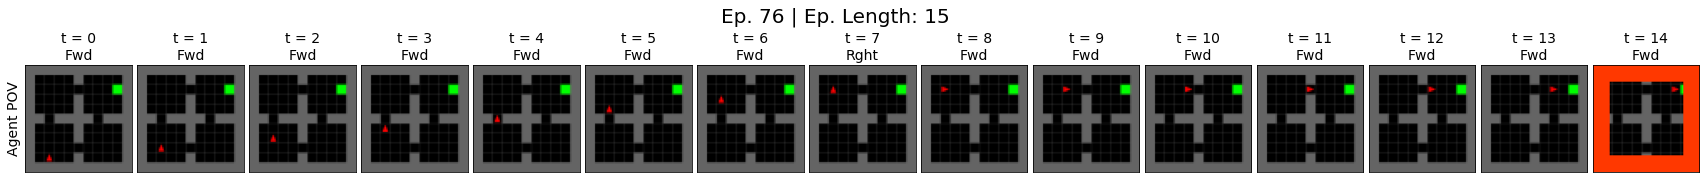

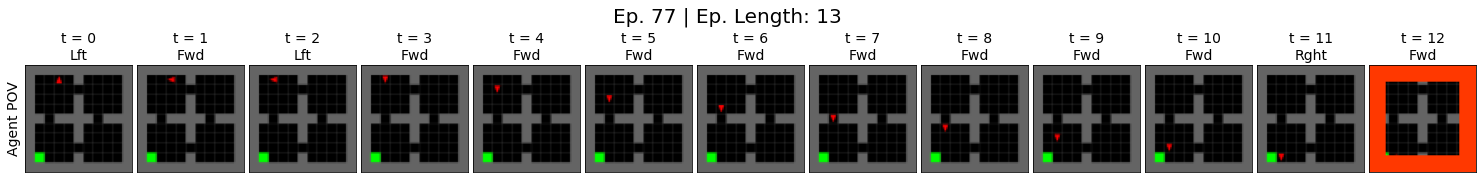

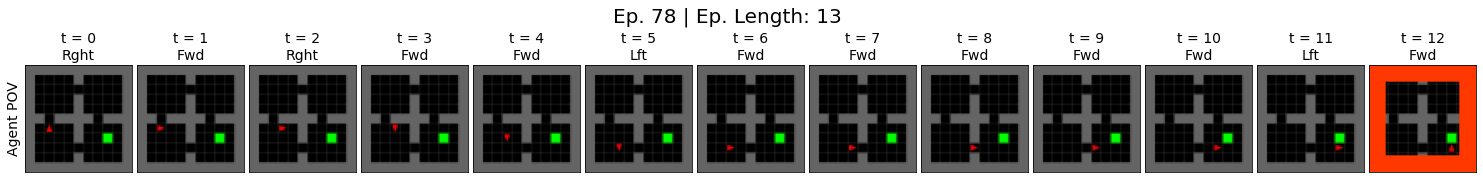

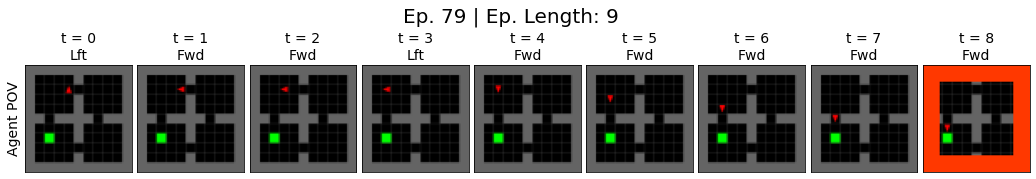

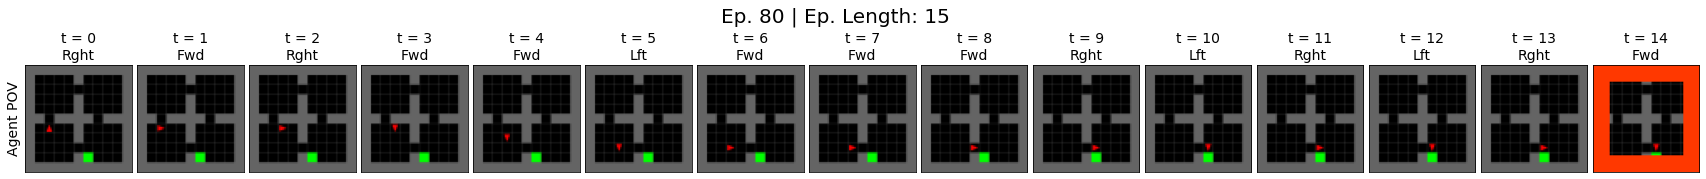

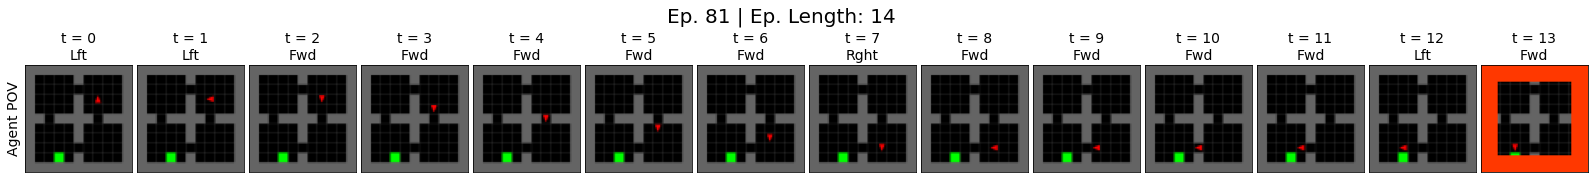

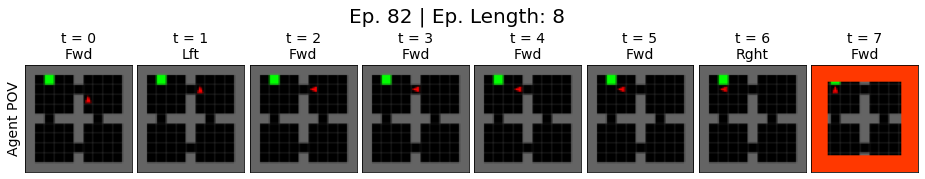

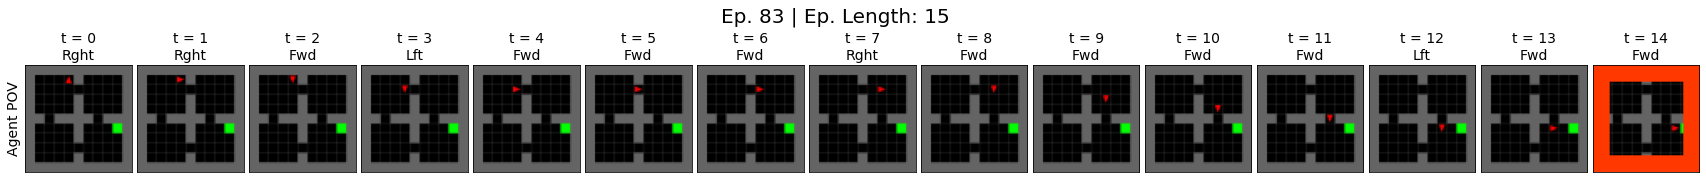

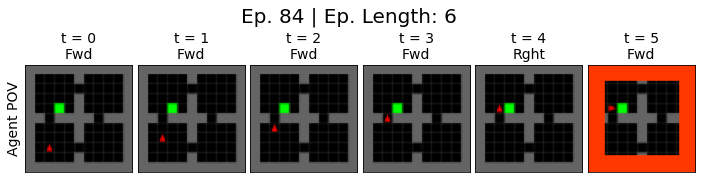

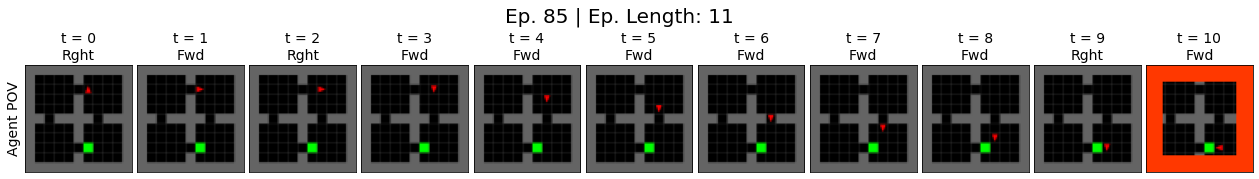

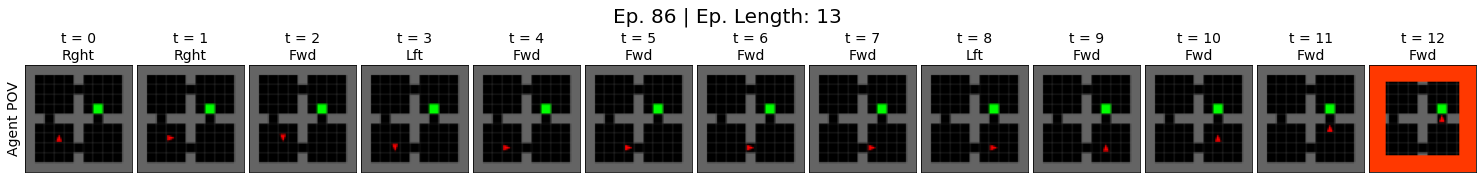

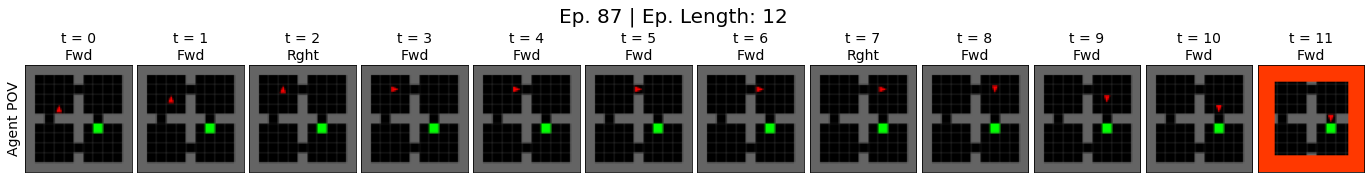

In [8]:
# Qualitative check of the data saved
# Plotting stuff
PLOT_SCALE = 1.
AX_WIDTH, AX_HEIGHT = 2,2
EP_TO_PLOT = len(ep_lengths) # N rows
from hwm.gym_minigrid.metadata import ACTION_META_DICT
from hwm.utils import draw_color_over_frame
COOL_GREY = (0.55,0.57,0.67)
COQUELICOT = (1.0, .22, .0)
# NOTE: if the env masks some actions, need to accout for it later
# HWM Hyper parameters
hwm_init_size = 3

for ep_idx, (ep_agent_obs_list, ep_action_list, ep_terminal_list) in \
    enumerate(zip(train_dset["observations"], train_dset["actions"], train_dset["terminals"])):
    ep_length = len(ep_agent_obs_list)
    
    fig, axes = plt.subplots(1, ep_length, 
        gridspec_kw = {'wspace': 0.05, 'hspace': 0.1}, 
        figsize=(AX_WIDTH * PLOT_SCALE * ep_length, 1 * AX_HEIGHT * PLOT_SCALE + 1.25)) # +1 is for to fit the title
    axes[0].set_ylabel("Agent POV", fontsize=14)
    fig.patch.set_facecolor("white")
    
    for t, (agent_obs, act, done) in enumerate(zip(ep_agent_obs_list, ep_action_list, ep_terminal_list)):
        agent_obs = agent_obs.transpose(1,2,0)

        # if t < hwm_init_size or t >= ep_length + hwm_init_size:
        #     agent_obs = draw_color_over_frame(agent_obs, COOL_GREY, normalized=False)
        if done == 1.0:
            agent_obs = draw_color_over_frame(agent_obs, COQUELICOT, normalized=False)
        axes[t].imshow(agent_obs)

        act_idx = np.argmax(act)
        axes[t].set_title(f"t = {t}\n{ACTION_META_DICT[act_idx]}", fontsize=14)
        # Remove the ticks and label
        axes[t].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    
    # fig.tight_layout()
    fig.suptitle(f"Ep. {ep_idx} | Ep. Length: {ep_length}", fontsize=20)
    # if ep_idx == 0:
    #     break # DEBUG for only one episode first